In [1]:
import wandb
import torch,torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import *
from torch.optim import *
from tqdm import tqdm
import cv2
device = 'cuda'
PROJECT_NAME = 'Tesla-Stock-Prediction'

In [2]:
data = pd.read_csv('./data.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
data = data['High']

In [5]:
data = torch.from_numpy(np.array(data.tolist()))

In [6]:
class Model(Module):
    def __init__(self,neurons=128):
        super().__init__()
        self.neurons = neurons
        self.lstm1 = LSTMCell(1,self.neurons).to(device)
        self.lstm2 = LSTMCell(self.neurons,self.neurons).to(device)
        self.linear = Linear(self.neurons,1).to(device)
    
    def forward(self,X,future=0):
        outputs = []
        batch_size = X.size(0)
        h_t1 = torch.zeros(batch_size,self.neurons,dtype=torch.float32)
        c_t1 = torch.zeros(batch_size,self.neurons,dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.neurons,dtype=torch.float32)
        c_t2 = torch.zeros(batch_size,self.neurons,dtype=torch.float32)
        h_t1 = h_t1.to(device)
        c_t1 = c_t1.to(device)
        h_t2 = h_t2.to(device)
        c_t2 = c_t2.to(device)
        for X_batch in X.split(1,dim=1):
            X_batch = X_batch.to(device)
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            pred = pred.to(device)
            outputs.append(pred)
        for i in range(future):
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            pred = self.linear(h_t2)
            outputs.append(pred)
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [7]:
data_input = data.view(1,-1)[:1,:-1].to(device).float()
data_target = data.view(1,-1)[:1,1:].to(device).float()

In [8]:
model = Model().to(device)
criterion = MSELoss()
optimizer = LBFGS(model.parameters(),lr=0.8)

In [9]:
epochs = 100

In [10]:
# wandb.init(project=PROJECT_NAME,name='baseline')
# for _ in tqdm(range(epochs)):
#     def closure():
#         optimizer.zero_grad()
#         preds = model(data_input.float())
#         loss = criterion(preds,data_target)
#         wandb.log({'loss':loss.item()})
#         loss.backward()
#         return loss
#     optimizer.step(closure)
#     with torch.no_grad():
#         future = 100
#         preds = model(data_input,future)
#         loss = criterion(preds[:,:-future],data_target)
#         wandb.log({'loss val':loss.item()})
#     plt.figure(figsize=(12,6))
#     n = data_input.shape[1]
#     def draw(y_i,color):
#         plt.plot(np.arange(n),data_target.cpu().view(-1),color)
#         plt.plot(np.arange(n,n+future),y_i[n:].cpu().view(-1),color + ':')
#     draw(preds[0],'r')
#     plt.savefig('./preds/img.png')
#     plt.close()
#     wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})

 56%|█████▌    | 56/100 [23:50<18:44, 25.55s/it]


FileNotFoundError: [Errno 2] No such file or directory: './preds/img.png'

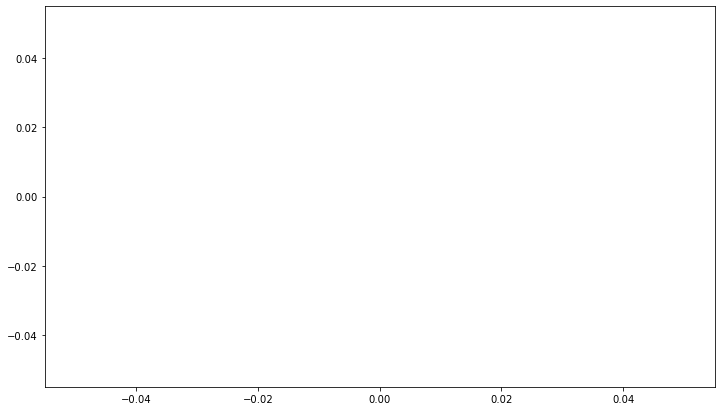

In [11]:
for _ in tqdm(range(epochs)):
    def closure():
        optimizer.zero_grad()
        preds = model(data_input)
        loss = criterion(preds,data_target)
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 100
        preds = model(data_input,future)
        loss = criterion(preds[:,:-future],data_target)
    plt.figure(figsize=(12,7))
    n = data_input.shape[1]
    def draw(y_i,c):
        plt.plot(np.arange(n),y_i[:n],'b')
        plt.plot(np.arange(n,n+future),y_i[n:],c + '-')
    draw(preds[0].cpu().view(-1),'r')
    plt.savefig('./preds/img.png')
    plt.close()